<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240121_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [1]:
%%capture

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [2]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.2.0'

In [3]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [4]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%d/%m/%Y')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1895 non-null   object        
 1   issuance_date     1895 non-null   datetime64[ns]
 2   issuance_year     1895 non-null   int64         
 3   issuance_week     1895 non-null   int64         
 4   monthfrac         1895 non-null   int64         
 5   eid_weeks         1895 non-null   int64         
 6   srbi_issuance     1895 non-null   int64         
 7   vix_indicator     1895 non-null   int64         
 8   bi_covid          1895 non-null   int64         
 9   gso_issuance      1895 non-null   int64         
 10  investment_grade  1895 non-null   int64         
 11  incoming_bid      1895 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 177.8+ KB


In [5]:
df_train00['issued_series'].value_counts()

sun10    292
sun20    287
spn12    272
sun15    272
sun05    266
spn03    238
sun30    170
spn09     76
sun07     11
sun08      8
sun04      1
vr04       1
sun02      1
Name: issued_series, dtype: int64

In [6]:
df_train00.describe()

,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1.895000e+03
mean,2017.138786,24.665963,124.200000,0.083905,0.030079,0.082322,0.249077,0.022691,0.860158,6.252043e+06
std,4.273546,14.044122,108.293944,0.277318,0.170850,0.274927,0.432592,0.148957,0.346914,5.907581e+06
min,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.361500e+06
50%,2018.000000,25.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.400000e+06
75%,2021.000000,37.000000,188.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.997500e+06
max,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

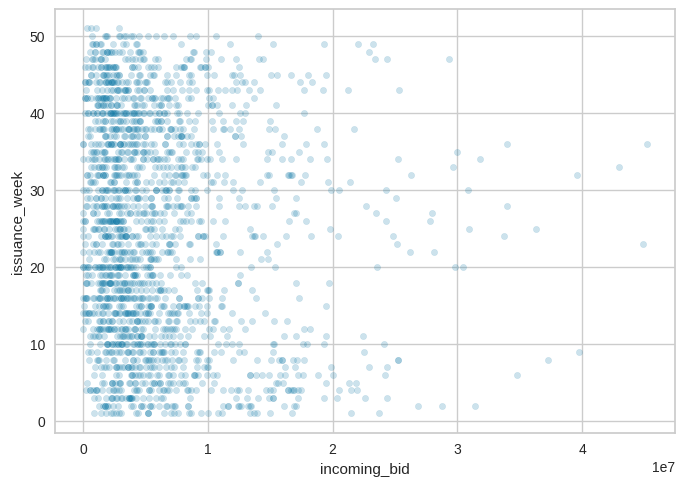

In [7]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

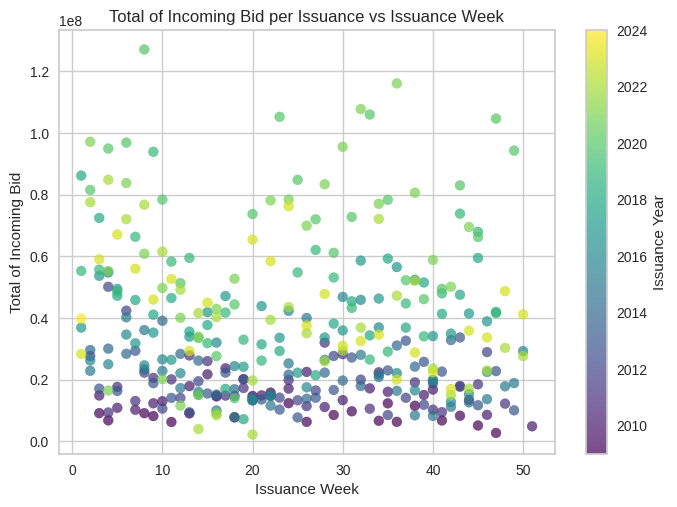

In [8]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

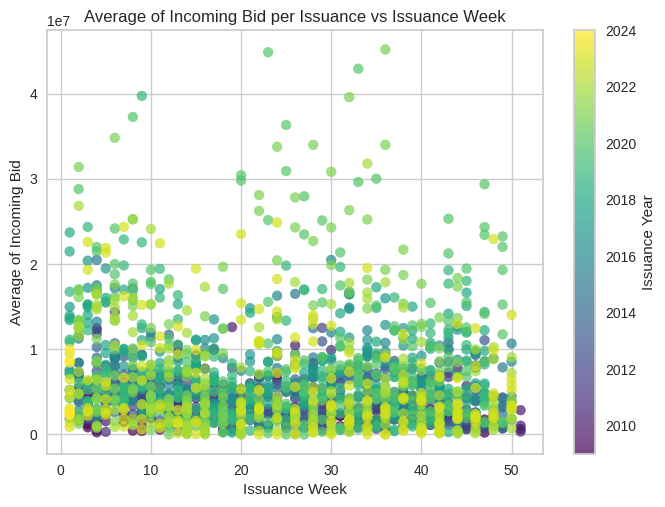

In [9]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [10]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

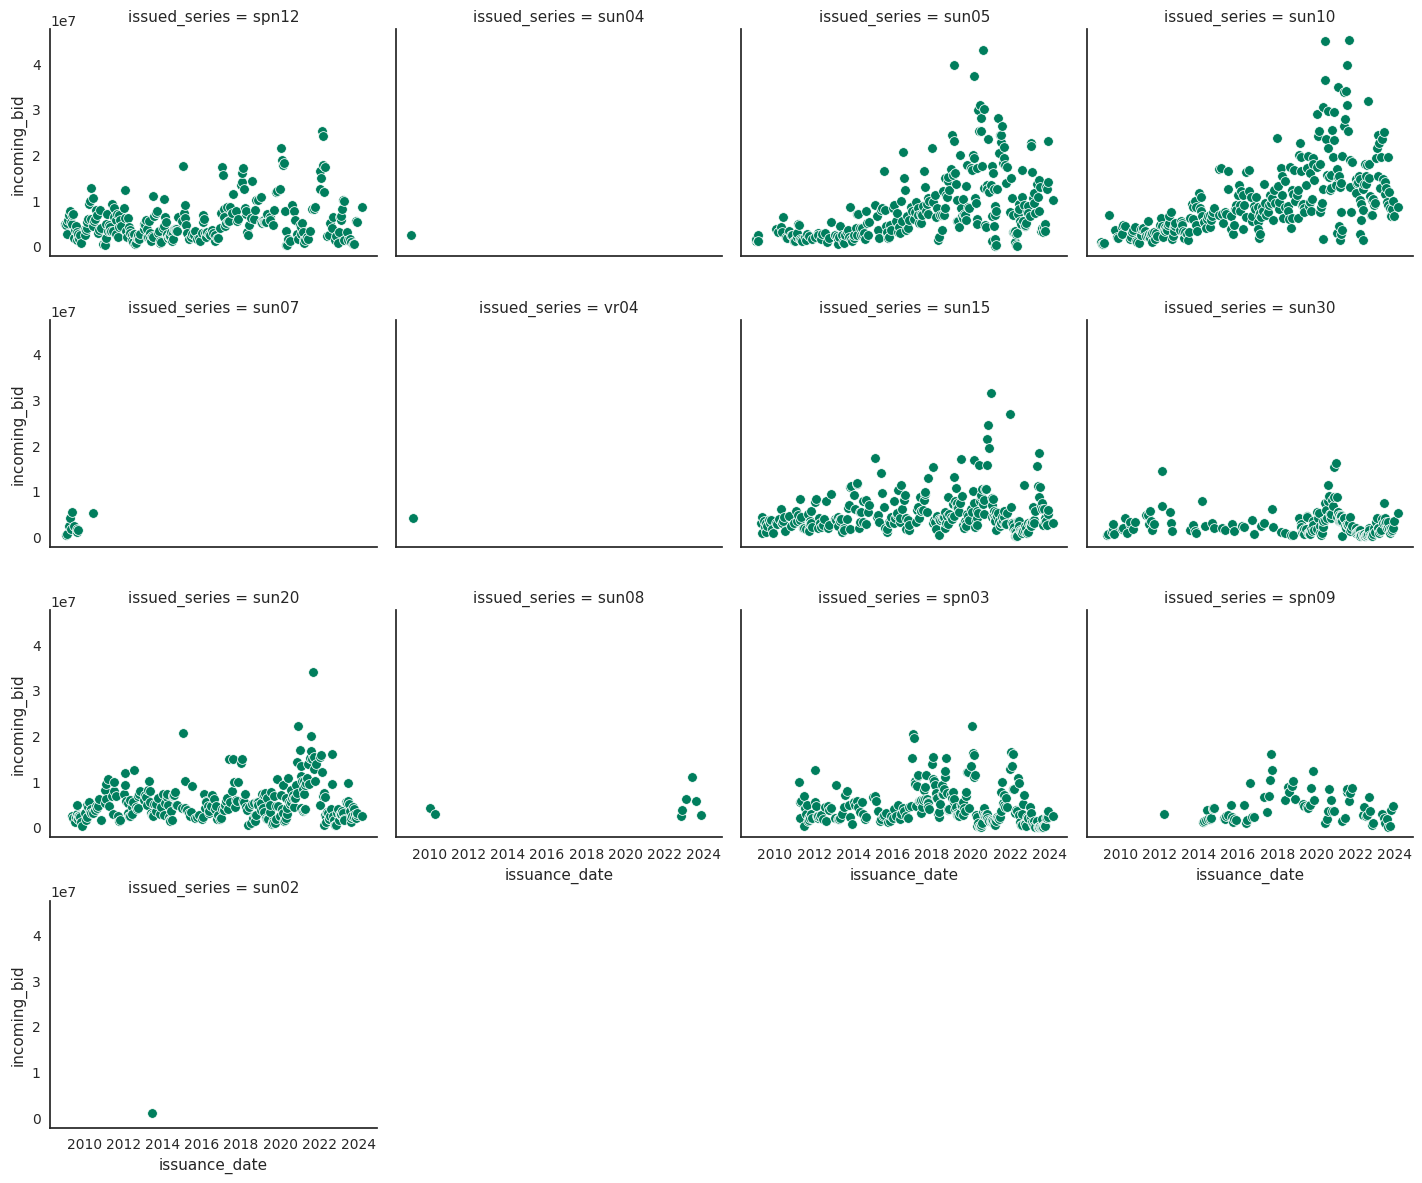

In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [12]:
corr_matrix = df_train00.corr()
corr_matrix['incoming_bid'].sort_values(ascending=False)

incoming_bid        1.000000
issuance_year       0.247464
investment_grade    0.193025
bi_covid            0.179578
eid_weeks          -0.010170
srbi_issuance      -0.046515
vix_indicator      -0.048545
issuance_week      -0.093471
gso_issuance       -0.100680
monthfrac          -0.101583
Name: incoming_bid, dtype: float64

In [13]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

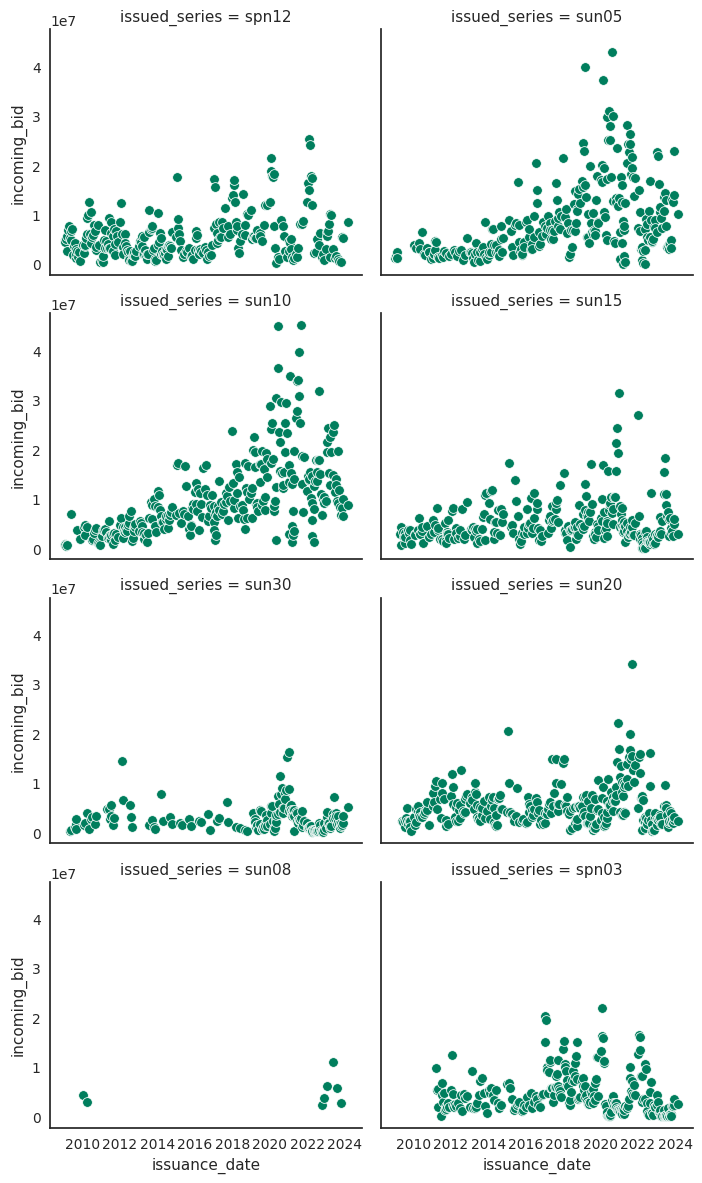

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [15]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

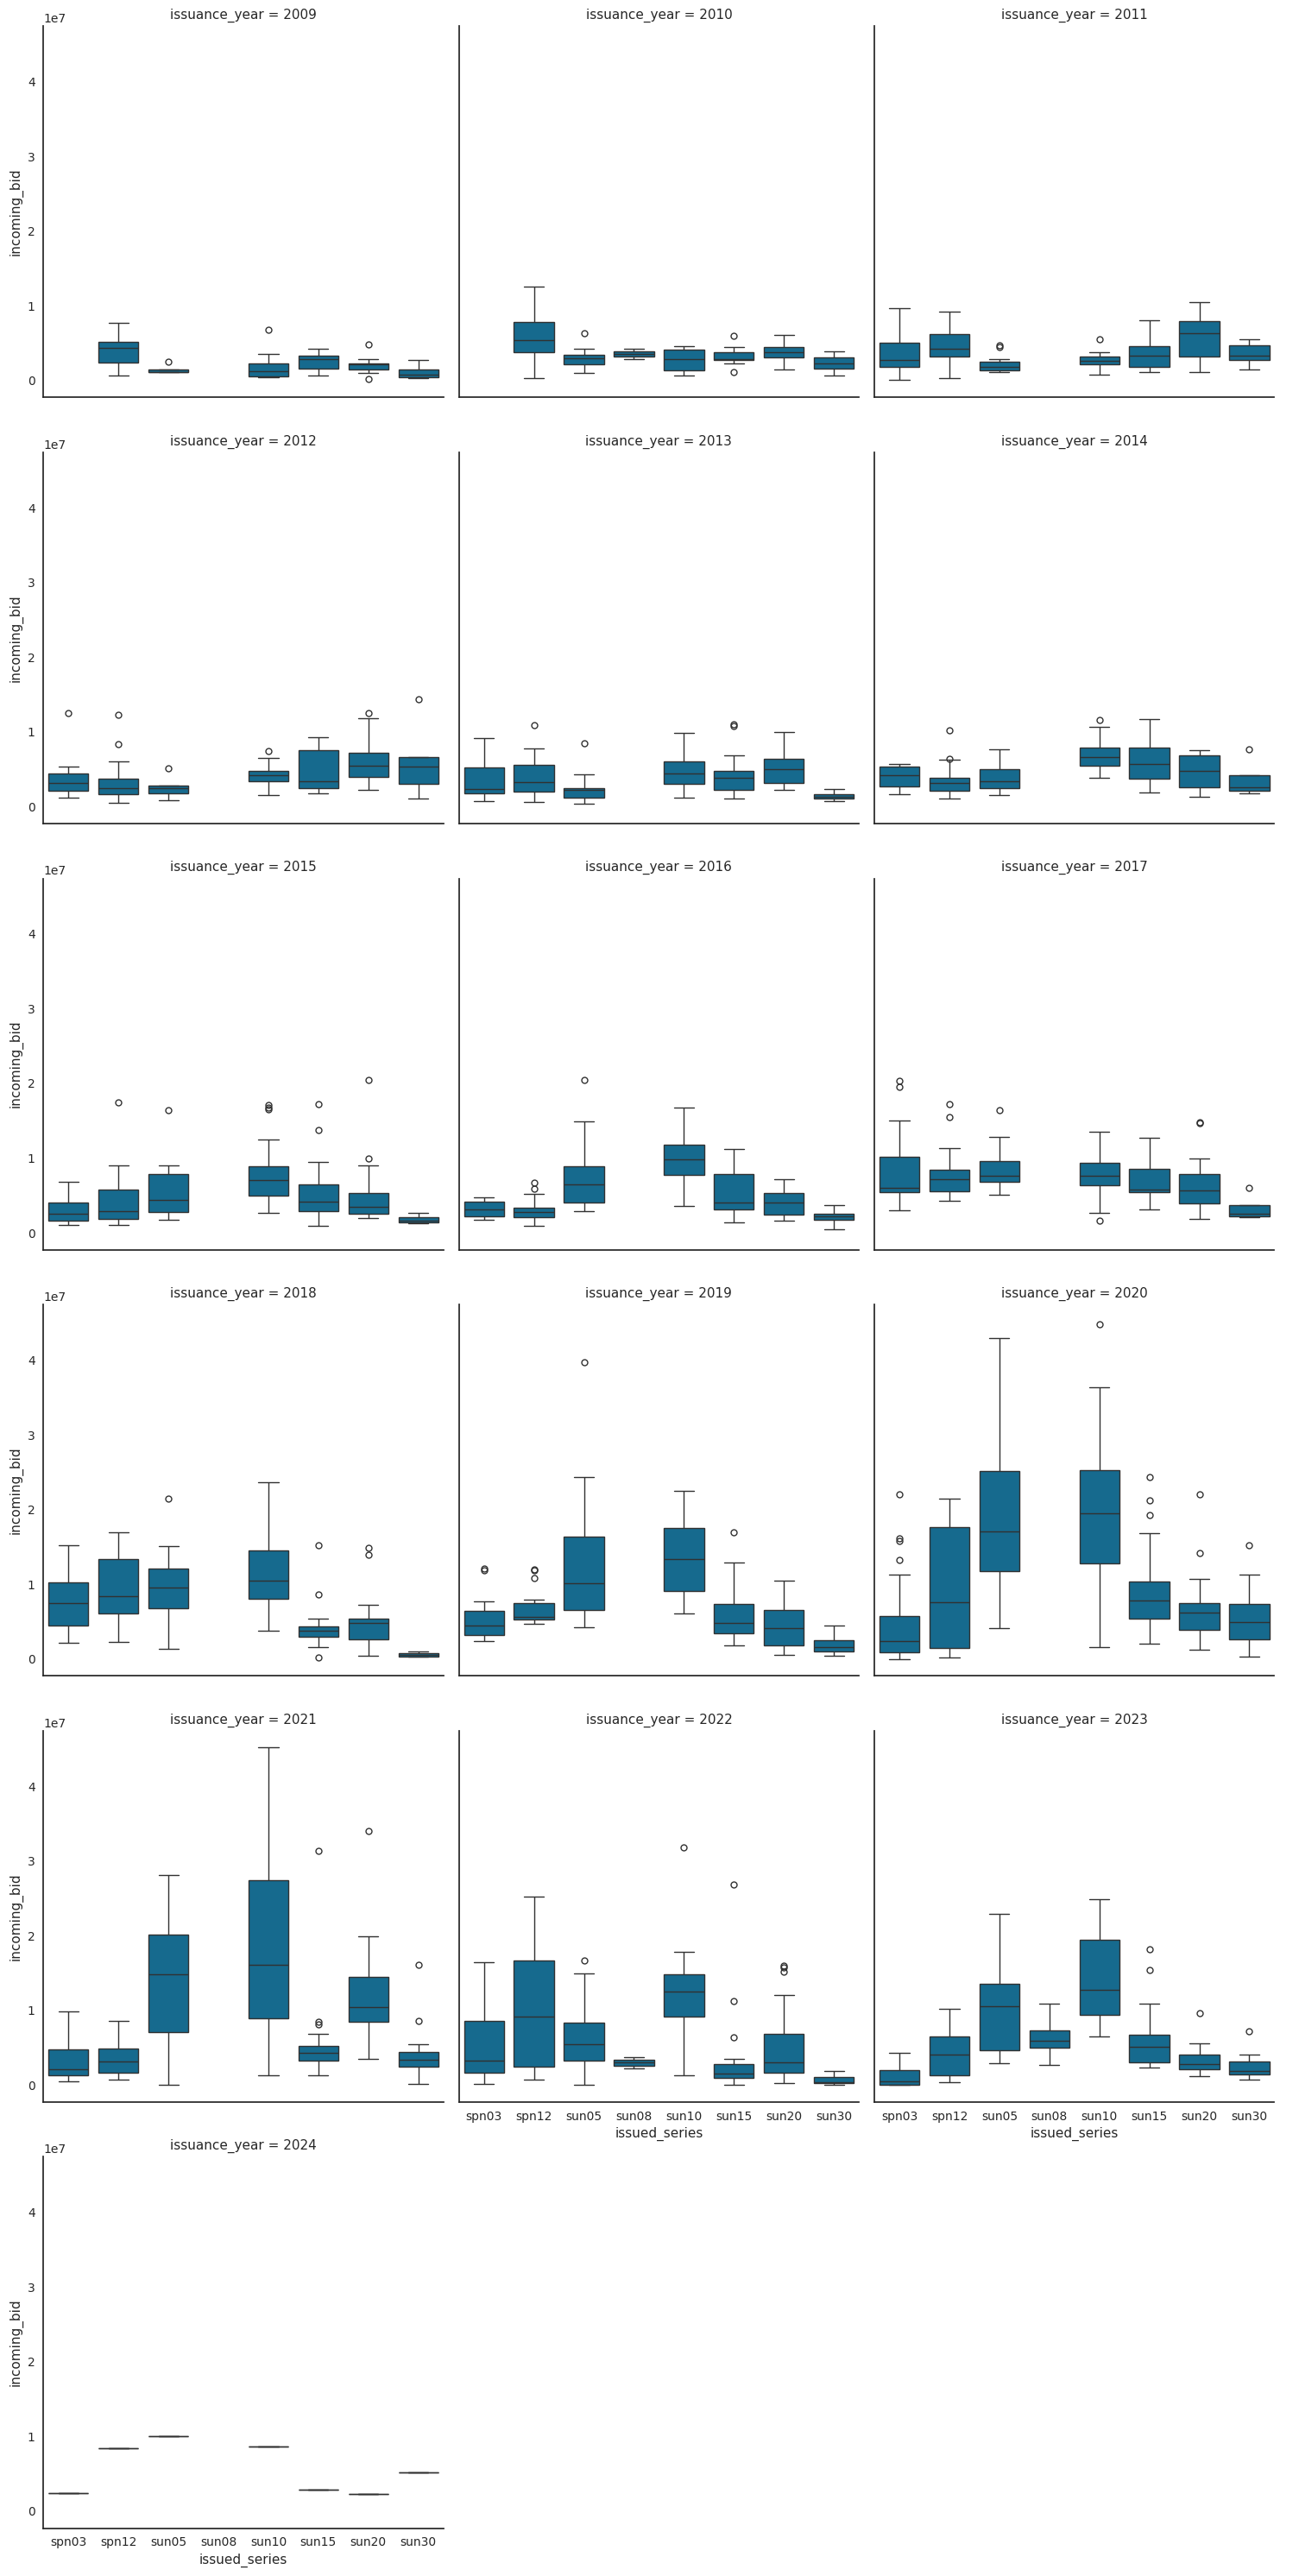

In [16]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [17]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [18]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1624, 12)
Test set shape: (181, 12)


In [20]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
sun10    263
sun20    258
sun15    245
spn12    245
sun05    239
spn03    214
sun30    153
sun08      7
Name: issued_series, dtype: int64 

Test: 
sun10    29
sun20    29
sun15    27
spn12    27
sun05    27
spn03    24
sun30    17
sun08     1
Name: issued_series, dtype: int64


In [21]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [22]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [23]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1805, 12)"
4,Transformed data shape,"(1805, 18)"
5,Transformed train set shape,"(1624, 18)"
6,Transformed test set shape,"(181, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [24]:
best01 = compare_models(sort = 'mse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,2377804.1125,12235733257420.8008,3475770.3500,0.6634,1.2310,0.9659,0.1310
et,Extra Trees Regressor,2347574.4358,12351320563331.2910,3497593.6885,0.6598,1.1025,0.9076,0.5830
lightgbm,Light Gradient Boosting Machine,2408138.9973,12430958226090.5039,3496096.1659,0.6606,1.2150,1.0367,0.8260
rf,Random Forest Regressor,2394185.2828,12550818868543.2070,3510842.1683,0.6578,1.1894,1.0635,0.5730
gbr,Gradient Boosting Regressor,2927108.8169,17869628712688.8438,4200307.1694,0.5131,1.3133,1.3733,0.1730
knn,K Neighbors Regressor,3110689.1250,19761180599910.3984,4421983.9250,0.4544,1.3196,1.8259,0.0690
dt,Decision Tree Regressor,2922448.9381,20376401589679.2422,4498121.3118,0.4382,1.2281,0.9747,0.0780
ada,AdaBoost Regressor,4074623.0890,26602333646971.2461,5132485.4209,0.2638,1.5390,3.5693,0.1340
ridge,Ridge Regression,3695802.8448,26780714732062.1133,5155901.8511,0.2676,1.4891,2.5549,0.1150
lasso,Lasso Regression,3702786.6213,26783591121036.9922,5156573.2494,0.2674,1.4858,2.5556,0.0930


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2447923.1332,12549077756880.8809,3542467.7496,0.6656,0.6380,0.6583
1,1888857.0836,6620236705122.5049,2572982.0647,0.7447,1.7229,0.9120
2,2220442.7891,9659215930549.0645,3107927.9159,0.7176,1.6948,1.7741
3,2314852.5610,9402975857933.5117,3066427.2139,0.6957,1.3175,0.7478
4,2598011.2076,16237570768592.8516,4029586.9228,0.5970,1.2284,0.6487
5,2292763.6549,10986649554822.4883,3314611.5240,0.7652,0.6012,0.5704
6,2499913.1753,16792693882178.5801,4097888.9543,0.5339,1.2990,0.6713
7,2484184.2824,14487391137076.0059,3806230.5680,0.6474,1.4137,1.8065
8,2666833.0996,12965274847887.9199,3600732.5432,0.6154,1.4648,1.4046


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

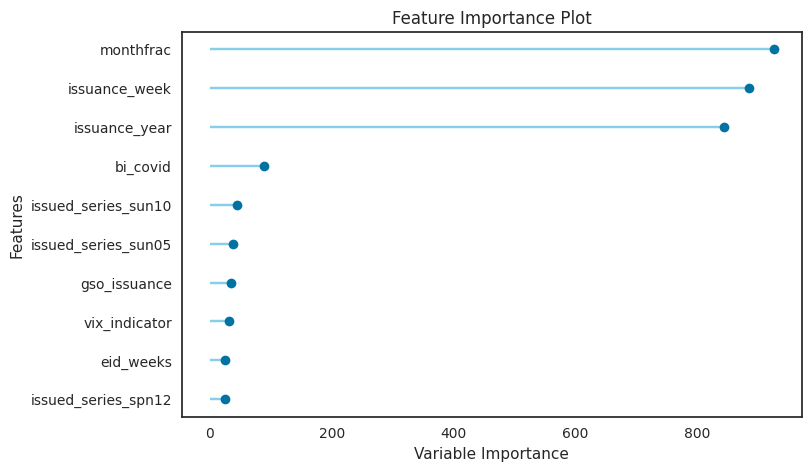

In [25]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2392756.0000,13864757362688.0000,3723541.0000,0.6306,0.6074,0.5877
1,1892654.3750,7478214918144.0000,2734632.5000,0.7117,1.7425,0.7972
2,2272895.5000,9843476791296.0000,3137431.5000,0.7123,1.7109,1.6004
3,2389876.2500,10781537075200.0000,3283525.0000,0.6511,1.3737,0.7250
4,2499495.0000,14283036426240.0000,3779290.5000,0.6455,1.3336,0.6384
5,2161184.7500,9410598404096.0000,3067669.7500,0.7989,0.6346,0.5104
6,2337104.5000,15125637496832.0000,3889169.2500,0.5802,1.2561,0.5409
7,2746125.0000,16522607067136.0000,4064801.0000,0.5979,1.4672,2.0924
8,2595643.7500,12369334894592.0000,3517006.5000,0.6330,1.4379,1.2320


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

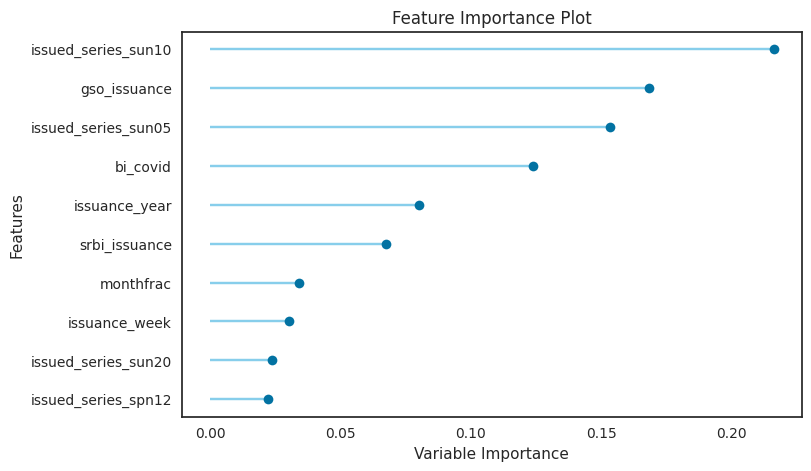

In [26]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2387620.8957,13669443195676.8965,3697221.0099,0.6358,0.5424,0.5436
1,1883655.0491,8869002224700.8398,2978087.0076,0.6580,1.5030,0.6797
2,2187765.4110,9462942453321.2031,3076189.5997,0.7234,1.6636,2.0811
3,2171716.6227,9853755875389.0195,3139069.2690,0.6811,1.0452,0.5869
4,2437609.9691,14272051096501.3027,3777836.8277,0.6458,1.2986,0.5609
5,2289833.5741,11284475894896.7227,3359237.3978,0.7588,0.5585,0.5473
6,2438625.1111,16000183452336.7461,4000022.9315,0.5559,1.1492,0.5646
7,2726986.6914,15622621162862.0000,3952546.1620,0.6198,1.1715,1.6262
8,2518629.7315,12699021801352.0234,3563568.6890,0.6233,1.4352,1.0960


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

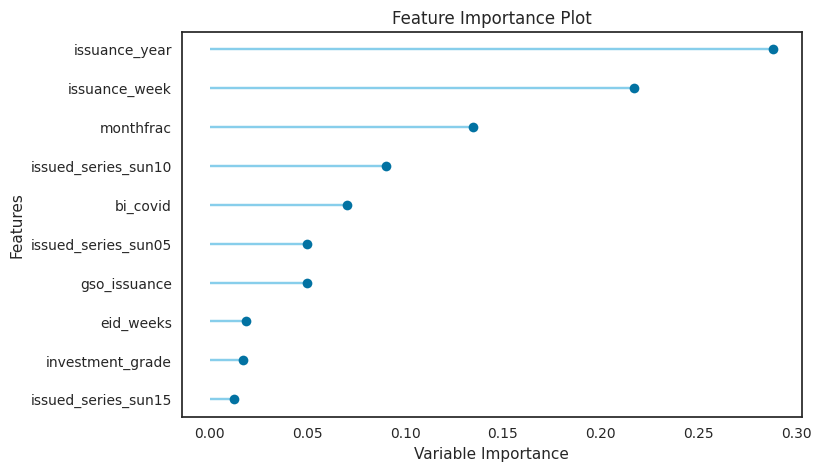

In [27]:
plot_model(create_model('et'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 66.06%

In [28]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2447923.1332,12549077756880.8809,3542467.7496,0.6656,0.6380,0.6583
1,1888857.0836,6620236705122.5049,2572982.0647,0.7447,1.7229,0.9120
2,2220442.7891,9659215930549.0645,3107927.9159,0.7176,1.6948,1.7741
3,2314852.5610,9402975857933.5117,3066427.2139,0.6957,1.3175,0.7478
4,2598011.2076,16237570768592.8516,4029586.9228,0.5970,1.2284,0.6487
5,2292763.6549,10986649554822.4883,3314611.5240,0.7652,0.6012,0.5704
6,2499913.1753,16792693882178.5801,4097888.9543,0.5339,1.2990,0.6713
7,2484184.2824,14487391137076.0059,3806230.5680,0.6474,1.4137,1.8065
8,2666833.0996,12965274847887.9199,3600732.5432,0.6154,1.4648,1.4046


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 59.53%

In [29]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2667652.4800,14748347419661.1719,3840357.7203,0.6070,0.7584,0.7248
1,2298830.4759,9645157356041.7188,3105665.3645,0.6281,1.8207,0.8252
2,2543181.7959,12940322461310.9512,3597265.9703,0.6217,1.8249,2.1041
3,2449525.9770,10824694050148.8555,3290090.2799,0.6497,1.2579,0.7060
4,2749657.4922,17307027285613.4590,4160171.5452,0.5705,1.1958,0.7898
5,2718132.9839,15025904174591.3477,3876326.1182,0.6788,0.6629,0.6486
6,2679240.8079,18983162489781.4688,4356967.1206,0.4731,1.1993,0.7216
7,2823866.3680,17069290424484.0410,4131499.7791,0.5845,1.4667,1.6081
8,2948814.4085,16094947372135.1465,4011850.8661,0.5225,1.4877,1.4720


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 67.65%

In [30]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2449569.9321,13213611619083.4102,3635053.1797,0.6479,0.7040,0.6194
1,1880342.6925,6749216533062.3486,2597925.4287,0.7398,1.7595,1.0127
2,2306108.9429,9903900934623.8320,3147046.3827,0.7105,1.7639,2.0096
3,2285169.0310,9163697915738.2734,3027160.0413,0.7034,1.3523,0.7195
4,2672354.3743,15525094855528.4902,3940189.6979,0.6147,1.3333,0.7117
5,2204529.5107,9841140477468.0781,3137059.2085,0.7896,0.5641,0.5091
6,2412722.1165,14655505466493.8633,3828250.9670,0.5932,1.3816,0.6474
7,2444900.1374,13564749327653.0293,3683035.3416,0.6698,1.3903,1.3296
8,2580026.8927,11930546941328.8359,3454062.3824,0.6461,1.4657,1.4376


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


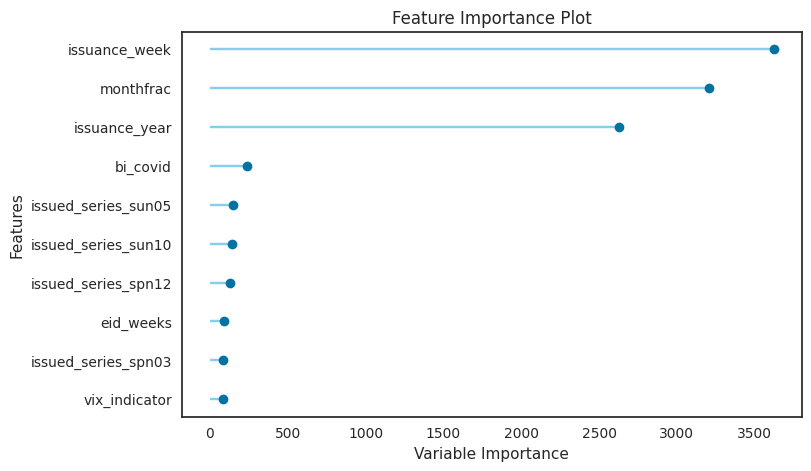

In [31]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 65.33%

In [32]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2441231.0599,13389893402508.5410,3659220.3271,0.6432,0.6195,0.6690
1,1801538.2414,6227043834944.1982,2495404.5433,0.7599,1.7095,0.8523
2,2315934.6903,9886291382714.0508,3144247.3476,0.7110,1.7341,1.4551
3,2339184.4301,9772476381434.1172,3126096.0288,0.6837,1.1589,0.7546
4,2684933.6944,16751139134236.4727,4092815.5510,0.5843,1.2191,0.7015
5,2255459.9044,10898545632888.7969,3301294.5389,0.7670,0.5607,0.5575
6,2499882.7124,16474647887598.7969,4058897.3734,0.5427,1.3316,0.6691
7,2480192.3909,14887183358869.1992,3858391.2916,0.6377,1.3749,1.4910
8,2679672.5584,13457211843438.1309,3668407.2625,0.6008,1.4406,1.3158


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.16%

In [33]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2493346.5303,13409442920370.4414,3661890.6210,0.6427,0.6123,0.6999
1,2004865.5582,7707756791879.0000,2776284.7102,0.7028,1.7887,1.1371
2,2331624.2548,9626855422598.4160,3102717.4255,0.7186,1.6616,1.2439
3,2397723.2820,10427567193502.2422,3229174.3826,0.6625,1.2658,0.7785
4,2686634.2297,15945445791989.9590,3993174.9013,0.6043,1.2762,0.7942
5,2213767.7388,9939376633855.0410,3152677.6927,0.7875,0.5511,0.5564
6,2450525.0436,15510051620961.7832,3938280.2873,0.5695,1.2540,0.6785
7,2594406.5090,15250086787549.8652,3905135.9499,0.6288,1.3883,1.1798
8,2623963.5800,12049972710214.4336,3471307.0608,0.6425,1.4237,1.3126


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 66.34%

In [34]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2392756.0000,13864757362688.0000,3723541.0000,0.6306,0.6074,0.5877
1,1892654.3750,7478214918144.0000,2734632.5000,0.7117,1.7425,0.7972
2,2272895.5000,9843476791296.0000,3137431.5000,0.7123,1.7109,1.6004
3,2389876.2500,10781537075200.0000,3283525.0000,0.6511,1.3737,0.7250
4,2499495.0000,14283036426240.0000,3779290.5000,0.6455,1.3336,0.6384
5,2161184.7500,9410598404096.0000,3067669.7500,0.7989,0.6346,0.5104
6,2337104.5000,15125637496832.0000,3889169.2500,0.5802,1.2561,0.5409
7,2746125.0000,16522607067136.0000,4064801.0000,0.5979,1.4672,2.0924
8,2595643.7500,12369334894592.0000,3517006.5000,0.6330,1.4379,1.2320


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 66.72%

In [35]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2369982.7500,13883542601728.0000,3726062.5000,0.6301,0.6180,0.5936
1,2014968.1250,8910477983744.0000,2985042.5000,0.6564,1.5876,0.8308
2,2086895.8750,8888869978112.0000,2981420.7500,0.7402,1.7270,3.2280
3,2207084.2500,9456661299200.0000,3075168.5000,0.6940,1.3240,0.6891
4,2497403.2500,13865462005760.0000,3723635.5000,0.6559,1.2244,0.6846
5,2315363.5000,11056377233408.0000,3325113.0000,0.7637,0.7401,0.5239
6,2465613.5000,15320880250880.0000,3914189.5000,0.5748,1.1572,0.5835
7,2633277.7500,16077079707648.0000,4009623.5000,0.6087,1.4269,1.2078
8,2637155.5000,12421517279232.0000,3524417.2500,0.6315,1.4524,1.2212


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 67.31%

In [36]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2386445.7500,12859194998784.0000,3585972.0000,0.6574,0.6042,0.6057
1,1813663.7500,6730310221824.0000,2594284.2500,0.7405,1.5982,0.7551
2,2219855.0000,9646360231936.0000,3105859.0000,0.7180,1.6479,0.7067
3,2109623.7500,8534060695552.0000,2921311.5000,0.7238,1.2577,0.6315
4,2549529.7500,14951712292864.0000,3866744.5000,0.6289,1.2522,0.6298
5,2285369.7500,11018213261312.0000,3319369.5000,0.7645,0.5590,0.5409
6,2423896.0000,15826472140800.0000,3978250.0000,0.5607,1.2485,0.5919
7,2573104.0000,15126311731200.0000,3889256.0000,0.6318,1.3929,1.3211
8,2593203.2500,12742578667520.0000,3569674.7500,0.6220,1.4391,1.4290


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


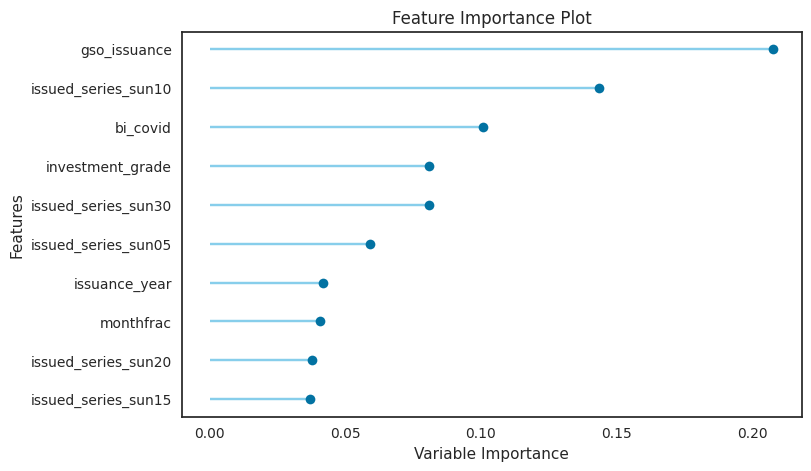

In [37]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 67.03%

In [38]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2326057.5000,13467247443968.0000,3669774.7500,0.6412,0.5677,0.5796
1,1781975.0000,6574946385920.0000,2564165.7500,0.7465,1.6103,0.6712
2,2203795.0000,9365661679616.0000,3060336.7500,0.7262,1.7068,1.2212
3,2246974.7500,10054709280768.0000,3170916.2500,0.6746,1.1856,0.6887
4,2536710.0000,15243966152704.0000,3904352.2500,0.6217,1.2492,0.6475
5,2208243.7500,10622907449344.0000,3259280.2500,0.7729,0.5290,0.5135
6,2332967.0000,15319616716800.0000,3914028.2500,0.5748,1.2615,0.5891
7,2556175.5000,15001418989568.0000,3873166.5000,0.6349,1.4049,1.1543
8,2629484.7500,12628328972288.0000,3553636.0000,0.6254,1.4030,1.2533


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 67.55%

In [39]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2327305.5000,11959354261504.0000,3458230.0000,0.6813,0.5879,0.6394
1,1840901.1250,7572461977600.0000,2751810.7500,0.7080,1.6589,0.6220
2,2233594.5000,9653430779904.0000,3106997.0000,0.7178,1.6897,1.2604
3,2230236.2500,9587484786688.0000,3096366.5000,0.6897,1.1678,0.6678
4,2406450.2500,13639838859264.0000,3693215.2500,0.6615,1.2659,0.6648
5,2257691.0000,11115732926464.0000,3334026.5000,0.7624,0.5689,0.5477
6,2485529.0000,16107688689664.0000,4013438.5000,0.5529,1.1352,0.6113
7,2573855.5000,15693090127872.0000,3961450.5000,0.6180,1.4001,1.0125
8,2580135.0000,11660017270784.0000,3414676.7500,0.6541,1.4179,1.2874


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

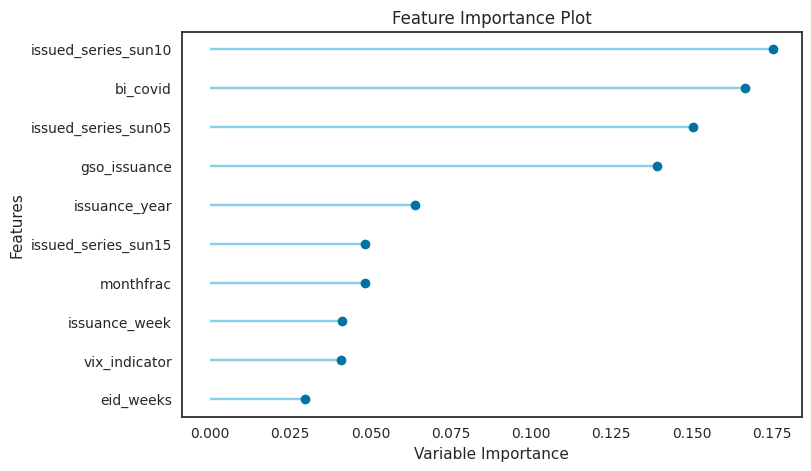

In [40]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 65.98%

In [41]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2387620.8957,13669443195676.8965,3697221.0099,0.6358,0.5424,0.5436
1,1883655.0491,8869002224700.8398,2978087.0076,0.6580,1.5030,0.6797
2,2187765.4110,9462942453321.2031,3076189.5997,0.7234,1.6636,2.0811
3,2171716.6227,9853755875389.0195,3139069.2690,0.6811,1.0452,0.5869
4,2437609.9691,14272051096501.3027,3777836.8277,0.6458,1.2986,0.5609
5,2289833.5741,11284475894896.7227,3359237.3978,0.7588,0.5585,0.5473
6,2438625.1111,16000183452336.7461,4000022.9315,0.5559,1.1492,0.5646
7,2726986.6914,15622621162862.0000,3952546.1620,0.6198,1.1715,1.6262
8,2518629.7315,12699021801352.0234,3563568.6890,0.6233,1.4352,1.0960


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 54.51%

In [42]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2797818.3189,16963688405644.6426,4118699.8441,0.5480,0.6647,0.7990
1,2138280.1991,9039439168291.0234,3006566.0093,0.6515,1.7940,1.0775
2,2842415.1140,14662177429445.2324,3829122.2792,0.5714,1.9120,5.6385
3,2465665.1744,11306247809039.5273,3362476.4399,0.6341,1.3412,0.8369
4,3020415.6089,20003860652159.4570,4472567.5682,0.5035,1.3914,0.9736
5,2726222.7908,16878673564698.5801,4108366.2890,0.6392,0.6256,0.7144
6,2894783.4652,21766671737469.1055,4665476.5820,0.3958,1.3751,0.8578
7,2908986.0326,19288498835155.8320,4391867.3517,0.5305,1.4365,2.6300
8,2962994.6367,16848691201370.7461,4104715.7272,0.5001,1.5574,1.7054


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 61.40%

In [43]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2518602.7029,13120872516770.2754,3622274.4950,0.6504,0.6144,0.7111
1,1922997.1656,7360476608472.0908,2713019.8319,0.7162,1.7562,1.1577
2,2452636.3684,11526738432956.1172,3395105.0695,0.6631,1.7855,3.0051
3,2276559.9141,10279952373046.9082,3206236.4811,0.6673,1.2797,0.7447
4,2813598.9222,17516858015066.6660,4185314.5658,0.5653,1.3675,0.8520
5,2494096.2168,14990355691003.6289,3871738.0711,0.6796,0.5824,0.6284
6,2650527.0707,17851705896256.6094,4225127.9148,0.5045,1.3061,0.7694
7,2894590.5602,18875223638636.3320,4344562.5371,0.5406,1.3587,2.3508
8,2627931.1504,13255116126172.9375,3640757.6308,0.6068,1.4593,1.5222


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 66.49%

In [44]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2429152.4655,13250501258266.9082,3640123.7971,0.6469,0.5625,0.5863
1,1786059.3859,7243861354708.8896,2691442.2444,0.7207,1.5668,0.7203
2,2254283.1682,9915473415876.4609,3148884.4717,0.7102,1.7390,2.3917
3,2254548.6990,10079149492253.7305,3174767.6281,0.6738,1.1693,0.6551
4,2445736.7521,13602870249705.8301,3688206.9153,0.6624,1.2605,0.6262
5,2317682.4377,11840842904471.0059,3441052.5867,0.7469,0.5526,0.5632
6,2428248.7606,16334966140112.7383,4041653.8867,0.5466,1.2331,0.5969
7,2656961.3172,15350402869733.5879,3917959.0184,0.6264,1.2882,1.8104
8,2421481.8463,11288315705901.5156,3359808.8794,0.6651,1.4054,1.1409


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.80%

In [45]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2444613.1490,14055816458800.7480,3749108.7553,0.6255,0.5734,0.6150
1,1891633.6012,8329052302773.8096,2886009.7544,0.6789,1.6151,0.7741
2,2148240.0463,8902905747462.5488,2983773.7427,0.7398,1.6558,2.2735
3,2112813.1166,9264367045298.4785,3043742.2764,0.7002,1.2098,0.6174
4,2515637.8704,15094108613413.1895,3885113.7195,0.6254,1.2959,0.6486
5,2211421.1003,11060111269758.8281,3325674.5586,0.7636,0.5201,0.5220
6,2395424.6130,14645351706953.9453,3826924.5756,0.5935,1.2011,0.6072
7,2722520.1037,15314861397118.0488,3913420.6772,0.6272,1.3057,1.4014
8,2506247.8884,11778360700630.0176,3431961.6403,0.6506,1.3773,1.2392


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

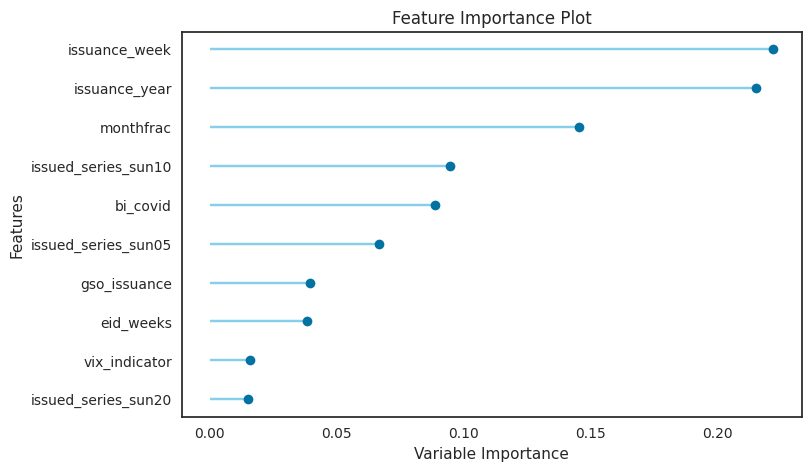

In [46]:
plot_model(et_boosted, plot = 'feature')

# Choosen

## Blended -- 56.80%

In [47]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_boosted, et_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2266068.7998,11549954890436.2754,3398522.4570,0.6922,0.5507,0.5788
1,1755690.8120,6543814156791.5596,2558087.9885,0.7477,1.4515,0.6248
2,2129246.9175,8499879464465.0732,2915455.2757,0.7515,1.5608,0.7060
3,2085870.9290,8220721711431.5020,2867180.0975,0.7340,1.1957,0.6410
4,2412124.0922,13646406353341.2637,3694104.2694,0.6613,1.2740,0.6383
5,2133359.3649,9907265310244.1113,3147580.8664,0.7882,0.5145,0.5033
6,2325510.0874,14309724125676.6113,3782819.5999,0.6028,1.1918,0.5836
7,2447001.1578,13686309905993.7441,3699501.3050,0.6669,1.3654,1.1946
8,2428986.5456,10329665126210.7324,3213979.6400,0.6935,1.3966,1.2878


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [48]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2331911.8442,12671199404372.8945,3559662.8217,0.5680,1.0993,0.5240


In [49]:
# plot_model(blended, plot = 'residuals')

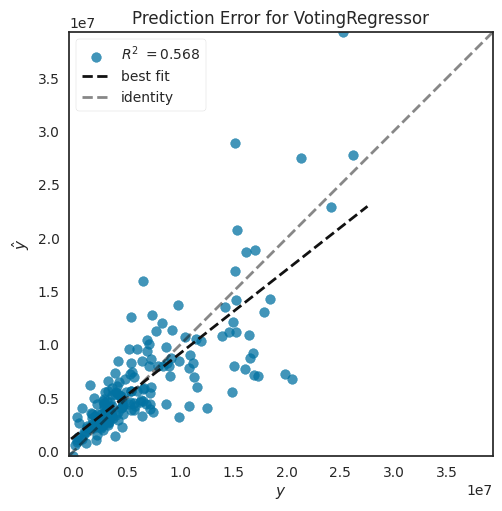

In [50]:
plot_model(blended, plot = 'error')

## Stacked -- 56.45%

In [51]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_boosted, et_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2366325.0902,11965445455546.5898,3459110.5006,0.6812,0.5976,0.6091
1,1740770.6148,6346671179949.1064,2519260.0461,0.7553,1.6723,0.7540
2,2110518.5068,8291007834645.5537,2879411.0222,0.7576,1.6129,0.8999
3,2044323.1086,8060745750391.1377,2839145.2500,0.7391,1.1801,0.6139
4,2448763.9926,13853313186362.4062,3722003.9208,0.6562,1.2759,0.6145
5,2139225.3343,9908971024960.5879,3147851.8112,0.7882,0.5201,0.4897
6,2357249.4902,13882435412542.7832,3725914.0372,0.6147,1.0678,0.6212
7,2424893.6884,13360822583692.8867,3655245.8992,0.6748,1.3385,0.8618
8,2376878.1007,10155128490352.3320,3186711.2342,0.6987,1.3714,1.2640


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [52]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2329032.2625,12773787924673.3086,3574043.6378,0.5645,1.0978,0.4925


In [53]:
# plot_model(stacked, plot = 'residuals')

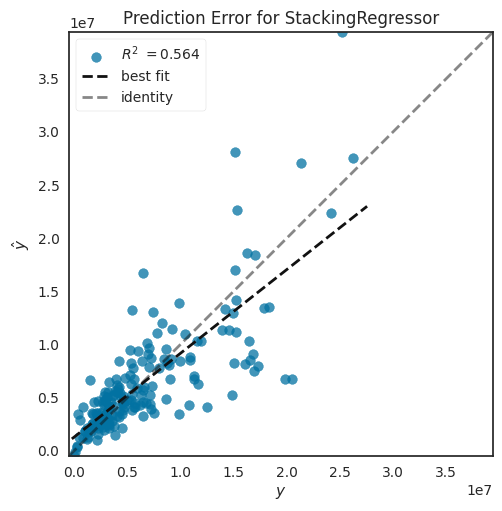

In [54]:
plot_model(stacked, plot = 'error')

## Finalizing -- 97.19%

In [55]:
final = finalize_model(blended)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,703373.4928,824095815656.6243,907797.2327,0.9719,1.0239,0.2006


In [56]:
save_model(final, '20240121_blended01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                                                        max_leaves=None,
                                                                                        min_child_weight=None,
                                                                                        missin

# Lelang 16 Jan 2024

## Load

In [57]:
lelang20240116 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240116')
lelang20240116['issuance_date'] = pd.to_datetime(lelang20240116['issuance_date'], format='%d/%m/%Y')
lelang20240116.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   monthfrac         7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Predict

In [58]:
# predict model on new_data
predict03= predict_model(final, data = lelang20240116)
predict03

,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-16,2024,3,3,0,1,0,0,0,1,3.812216e+06
1,spn12,2024-01-16,2024,3,12,0,1,0,0,0,1,7.217348e+06
2,sun05,2024-01-16,2024,3,62,0,1,0,0,0,1,1.402399e+07
3,sun10,2024-01-16,2024,3,120,0,1,0,0,0,1,1.565865e+07
4,sun15,2024-01-16,2024,3,172,0,1,0,0,0,1,6.560199e+06
5,sun20,2024-01-16,2024,3,232,0,1,0,0,0,1,3.999221e+06
6,sun30,2024-01-16,2024,3,365,0,1,0,0,0,1,4.701794e+06


In [59]:
# @title Lelang 20240116: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-16    |      3.81 trillion |
| spn12           |   2024-01-16    |      7.22 trillion |
| sun05           |   2024-01-16    |     14.02 trillion |
| sun10           |   2024-01-16    |     15.66 trillion |
| sun15           |   2024-01-16    |      6.56 trillion |
| sun20           |   2024-01-16    |      4.00 trillion |
| sun30           |   2024-01-16    |      4.70 trillion |


In [60]:
# @title Lelang 20240116: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 56.80%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 56.80%,
the estimated incoming bid for the next issuance is approximately Rp55,973,413.62 million
or Rp55.97 trillion.

